### Overview: This EDA aims to understand the joined table and conduct neccessary feature engineering for modeling. The goal is to predict daily sales of 5 families across 18 stores in Quito.

### Table of Contents:

1. Read the Full Table
2. Nulls and Imputation
3. Chcek for Distributions
4. One Hot Encoding
5. Datetime Feature Engineering

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### 1. Read Full Table

In [45]:
df = pd.read_csv("quito_whole.csv")
# set the date column to datetime
df["date"]=pd.to_datetime(df["date"])
# set the "date" as index
df.set_index("date", inplace=True)
df.head()

,store_nbr,family,sales,onpromotion,city,state,sto_type,cluster,dcoilwtico,holi_type,locale,description_eng,transactions
date,,,,,,,,,,,,,
2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,93.14,Holiday,National,First day of the year,NaN
2013-01-01,1,CLEANING,0.0,0,Quito,Pichincha,D,13,93.14,Holiday,National,First day of the year,NaN
2013-01-01,1,DAIRY,0.0,0,Quito,Pichincha,D,13,93.14,Holiday,National,First day of the year,NaN
2013-01-01,1,GROCERY I,0.0,0,Quito,Pichincha,D,13,93.14,Holiday,National,First day of the year,NaN
2013-01-01,1,PRODUCE,0.0,0,Quito,Pichincha,D,13,93.14,Holiday,National,First day of the year,NaN


In [46]:
df.rename(columns={"transactions": "store_trans"}, inplace=True)

In [47]:
df.head()

,store_nbr,family,sales,onpromotion,city,state,sto_type,cluster,dcoilwtico,holi_type,locale,description_eng,store_trans
date,,,,,,,,,,,,,
2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,93.14,Holiday,National,First day of the year,NaN
2013-01-01,1,CLEANING,0.0,0,Quito,Pichincha,D,13,93.14,Holiday,National,First day of the year,NaN
2013-01-01,1,DAIRY,0.0,0,Quito,Pichincha,D,13,93.14,Holiday,National,First day of the year,NaN
2013-01-01,1,GROCERY I,0.0,0,Quito,Pichincha,D,13,93.14,Holiday,National,First day of the year,NaN
2013-01-01,1,PRODUCE,0.0,0,Quito,Pichincha,D,13,93.14,Holiday,National,First day of the year,NaN


In [48]:
# drop city and state since there is only one value
df = df.drop(columns=["city","state"])
df.head()

,store_nbr,family,sales,onpromotion,sto_type,cluster,dcoilwtico,holi_type,locale,description_eng,store_trans
date,,,,,,,,,,,
2013-01-01,1,BEVERAGES,0.0,0,D,13,93.14,Holiday,National,First day of the year,NaN
2013-01-01,1,CLEANING,0.0,0,D,13,93.14,Holiday,National,First day of the year,NaN
2013-01-01,1,DAIRY,0.0,0,D,13,93.14,Holiday,National,First day of the year,NaN
2013-01-01,1,GROCERY I,0.0,0,D,13,93.14,Holiday,National,First day of the year,NaN
2013-01-01,1,PRODUCE,0.0,0,D,13,93.14,Holiday,National,First day of the year,NaN


#### 2. Missing values and imputation

In [49]:
# check for missing values from rest of the features
df.isna().sum()

store_nbr               0
family                  0
sales                   0
onpromotion             0
sto_type                0
cluster                 0
dcoilwtico          43560
holi_type          138600
locale             138600
description_eng    138600
store_trans          5095
dtype: int64

In [50]:
# % of missing values
print(f"dcoilwtico missing:{round(43560/151920*100,2)}%")
print(f"store_trans missing:{round(5095/151920*100,2)}%")

dcoilwtico missing:28.67%
store_trans missing:3.35%


#### We need to impute dcoilwtico missing values and drop store_trans missing values; As for holiday related columns, since not each day is holiday, we will use current values for modeling.

In [51]:
# check for distinctive null values in "dcoilwtico" 
df_dcoil = df["dcoilwtico"].to_frame().reset_index().drop_duplicates()
df_dcoil.set_index("date", inplace=True)
df_dcoil["dcoilwtico"].info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 1684 entries, 2013-01-01 to 2017-08-15
Series name: dcoilwtico
Non-Null Count  Dtype  
--------------  -----  
1203 non-null   float64
dtypes: float64(1)
memory usage: 26.3 KB


#### Visualize the nulls in dcoilwtico

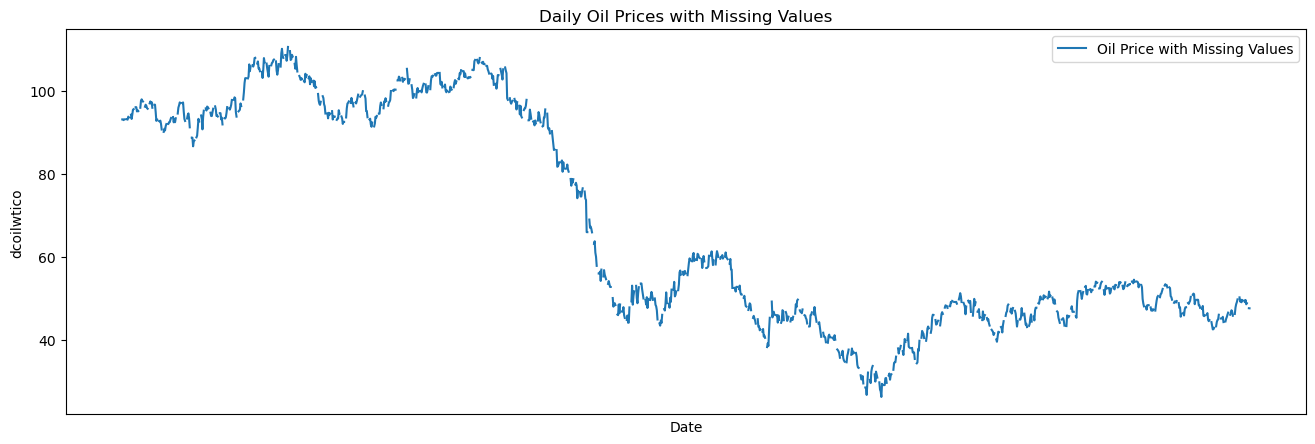

In [52]:
# Visualize the missing data
plt.figure(figsize=(16, 5))
plt.plot(df_dcoil.index, df_dcoil["dcoilwtico"], label='Oil Price with Missing Values')
plt.title('Daily Oil Prices with Missing Values')
plt.xlabel('Date')
plt.ylabel('dcoilwtico')
plt.xticks([])
plt.legend()
plt.show()

#### We can see that the null values are distributed sparsely throughout the whole dataset instead of concentrating in one area. Given that 29% of the data is missing, forward or backward filling is not suitable. Since the daily oil prices exhibit trends and seasonality, we can use a time series-specific interpolation method to fill the missing values.

In [53]:
# fill the nulls
df_dcoil["dcoilwtico_interpolated"]=df_dcoil["dcoilwtico"].interpolate(method="time")
# drop original column
# df_dcoil.drop(columns="dcoilwtico", inplace=True)
# sanity check
df_dcoil.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1684 entries, 2013-01-01 to 2017-08-15
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   dcoilwtico               1203 non-null   float64
 1   dcoilwtico_interpolated  1684 non-null   float64
dtypes: float64(2)
memory usage: 39.5 KB


In [54]:
# join df_dcoil with origial df
df= df.merge(df_dcoil, left_index=True, right_index=True, how = 'left')
# drop the old column
df=df.drop(columns= ["dcoilwtico_x", "dcoilwtico_y"])
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 151920 entries, 2013-01-01 to 2017-08-15
Data columns (total 11 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   store_nbr                151920 non-null  int64  
 1   family                   151920 non-null  object 
 2   sales                    151920 non-null  float64
 3   onpromotion              151920 non-null  int64  
 4   sto_type                 151920 non-null  object 
 5   cluster                  151920 non-null  int64  
 6   holi_type                13320 non-null   object 
 7   locale                   13320 non-null   object 
 8   description_eng          13320 non-null   object 
 9   store_trans              146825 non-null  float64
 10  dcoilwtico_interpolated  151920 non-null  float64
dtypes: float64(3), int64(3), object(5)
memory usage: 13.9+ MB


#### Drop nulls in "store_trans"

In [55]:
df = df.dropna(subset=["store_trans"])

#### 3. Check for the distributions of categorical data

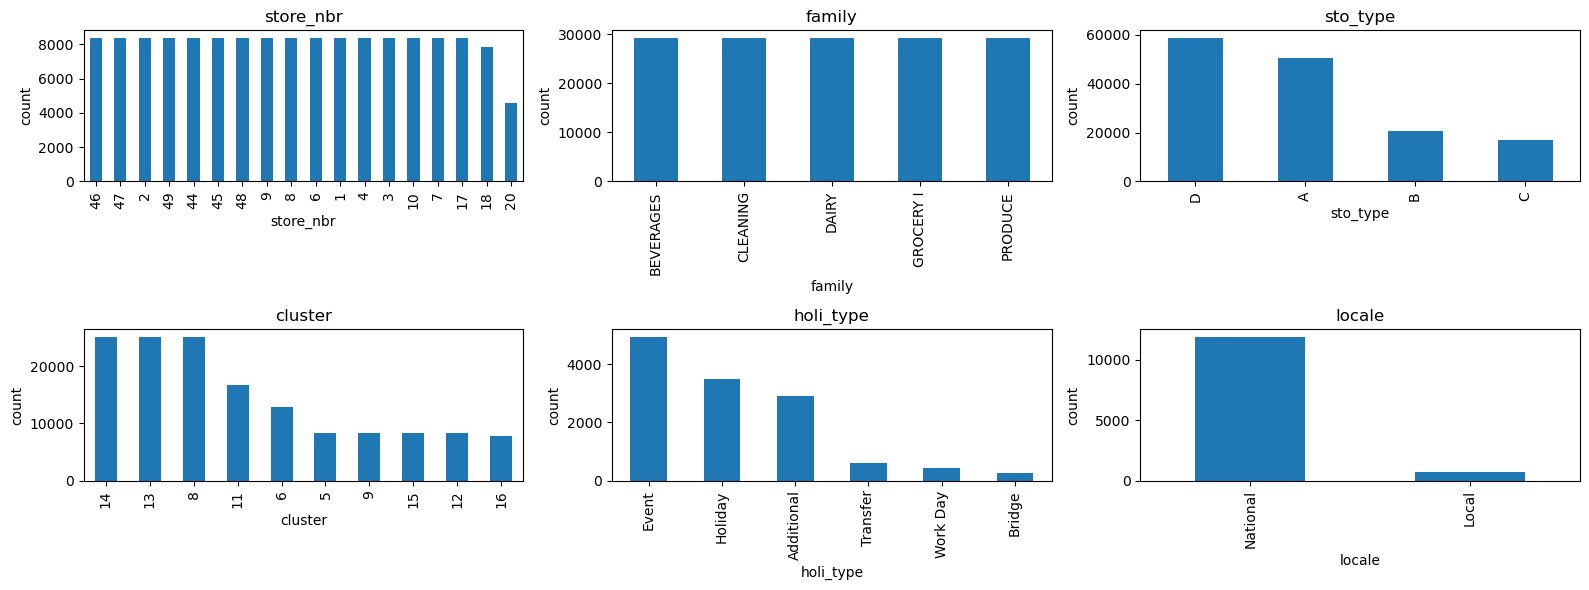

In [56]:
cols = ["store_nbr","family","sto_type","cluster","holi_type","locale"]
plt.subplots(2,3, figsize=(16,6))
for i, col in enumerate(cols):
    plt.subplot(2,3,i+1)
    df[col].value_counts().plot(kind="bar")
    plt.ylabel("count")
    plt.title(col)
plt.tight_layout()
plt.show()

In [57]:
# check for holidays
df["description_eng"].value_counts(ascending=False)

description_eng
Carnival                                      880
Holy Friday                                   440
Labor Day                                     440
MOTHER DAY-1                                  440
Mother's Day                                  440
                                             ... 
WORLD OF FOOTBALL BRAZIL: ECUADOR-HONDURAS     85
WORLD OF FOOTBALL BRAZIL: ECUADOR-SUIZA        85
World Football Inauguration Brazil             85
Deceased day                                   85
RECOVERY DAY OF THE DEAD                       85
Name: count, Length: 69, dtype: int64

#### 4. Use one hot coding for the above categorical columns and description_eng

In [58]:
# change the categorical columns from numbers to string
df["store_nbr"] = df["store_nbr"].astype(str)
df["cluster"] = df["cluster"].astype(str)
# sanity check
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 146825 entries, 2013-01-02 to 2017-08-15
Data columns (total 11 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   store_nbr                146825 non-null  object 
 1   family                   146825 non-null  object 
 2   sales                    146825 non-null  float64
 3   onpromotion              146825 non-null  int64  
 4   sto_type                 146825 non-null  object 
 5   cluster                  146825 non-null  object 
 6   holi_type                12625 non-null   object 
 7   locale                   12625 non-null   object 
 8   description_eng          12625 non-null   object 
 9   store_trans              146825 non-null  float64
 10  dcoilwtico_interpolated  146825 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 13.4+ MB


In [59]:
df_encoded = pd.get_dummies(df,columns=['store_nbr','family','sto_type','cluster','holi_type','locale','description_eng'], dtype='int')
df_encoded.head()

,sales,onpromotion,store_trans,dcoilwtico_interpolated,store_nbr_1,store_nbr_10,store_nbr_17,store_nbr_18,store_nbr_2,store_nbr_20,...,description_eng_WORLD OF FOOTBALL BRAZIL: ECUADOR-HONDURAS,description_eng_WORLD OF FOOTBALL BRAZIL: ECUADOR-SUIZA,description_eng_WORLD OF FOOTBALL BRAZIL: Ecuador-France,description_eng_WORLD OF FOOTBALL BRAZIL: Eighth of Final,description_eng_WORLD OF FOOTBALL BRAZIL: FINAL,description_eng_World Cup Brazil: Quarter Final,description_eng_World Cup Brazil: Semifinals,description_eng_World Cup Brazil: Third and fourth place,description_eng_World Football Inauguration Brazil,description_eng_foundation of Quito
date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,1091.0,0,2111.0,93.14,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-01-02,1060.0,0,2111.0,93.14,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-01-02,579.0,0,2111.0,93.14,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-01-02,2652.0,0,2111.0,93.14,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-01-02,0.0,0,2111.0,93.14,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### 5. Feature engineering of date

In [60]:
df_encoded.reset_index(inplace=True)
df_encoded["year"]=df_encoded["date"].dt.year
df_encoded["month"]=df_encoded["date"].dt.month
df_encoded["day"]=df_encoded["date"].dt.day
df_encoded["weekday"]=np.where(df_encoded["date"].dt.weekday<5,df_encoded["date"].dt.weekday+1,0)
df_encoded["weekend"]=np.where(df_encoded["date"].dt.weekday>=5,1,0)
df_encoded2 = df_encoded.drop(columns="date")

In [61]:
# sanity check
df_encoded2.head()

,sales,onpromotion,store_trans,dcoilwtico_interpolated,store_nbr_1,store_nbr_10,store_nbr_17,store_nbr_18,store_nbr_2,store_nbr_20,...,description_eng_World Cup Brazil: Quarter Final,description_eng_World Cup Brazil: Semifinals,description_eng_World Cup Brazil: Third and fourth place,description_eng_World Football Inauguration Brazil,description_eng_foundation of Quito,year,month,day,weekday,weekend
0,1091.0,0,2111.0,93.14,1,0,0,0,0,0,...,0,0,0,0,0,2013,1,2,3,0
1,1060.0,0,2111.0,93.14,1,0,0,0,0,0,...,0,0,0,0,0,2013,1,2,3,0
2,579.0,0,2111.0,93.14,1,0,0,0,0,0,...,0,0,0,0,0,2013,1,2,3,0
3,2652.0,0,2111.0,93.14,1,0,0,0,0,0,...,0,0,0,0,0,2013,1,2,3,0
4,0.0,0,2111.0,93.14,1,0,0,0,0,0,...,0,0,0,0,0,2013,1,2,3,0


In [62]:
df_encoded2["weekend"].value_counts()

weekend
0    104745
1     42080
Name: count, dtype: int64

In [63]:
# sanity check for null values
sum(df_encoded2.isnull().sum())

0

#### There are no null values in the dataset. All the columns are in numerical format. We can do a baseline model.

In [64]:
# save the dataset
df_encoded2.to_csv("full_data.csv", index=False)